In [1]:
cd /content/drive/MyDrive/논문/DCN

/content/drive/MyDrive/논문/DCN


In [2]:
ls

0105_DCN_like_predict.ipynb  user_test_v2.json
1220_dcn.ipynb               user_train_v2.json
test_v2_201130.json          Wine_segment_201229.csv
train_v2_201130.json         Wine_segment_scaled_201231.csv


In [3]:
!pip install -q tensorflow-recommenders
!pip install -q --upgrade tensorflow-datasets

     |████████████████████████████████| 51kB 5.0MB/s 
     |████████████████████████████████| 3.6MB 8.2MB/s 


In [4]:
import os
import sys
import gc
import glob
import joblib
from tqdm import tqdm

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
%matplotlib inline

import tensorflow as tf
import tensorflow_recommenders as tfrs

from tensorflow.keras.losses import binary_crossentropy
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Lambda, Input, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import LambdaCallback, EarlyStopping, Callback
from tensorflow.keras.utils import plot_model

# 0. Data Load

In [5]:
# 0. Data Load

In [6]:
train = pd.read_json('train_v2_201130.json')
test = pd.read_json('test_v2_201130.json')

In [7]:
train.head()

index  ... like
0      0  ...    1
1      1  ...    1
2      4  ...    1
3      5  ...    1
4      6  ...    0

[5 rows x 10 columns]

In [8]:
train.shape, test.shape

((763387, 10), (188718, 10))

In [9]:
item = pd.read_csv('Wine_segment_201229.csv')

In [10]:
item.head()

wine_id                        name  ...  winery_id  segment
0  1938520     1882 Cabernet Sauvignon  ...     2412.0        2
1    14604      Les Bessards Hermitage  ...     7636.0        2
2  1930757      Patriarch Estate Grown  ...     1905.0        2
3  1564280                      Merlot  ...     1297.0        2
4  2576427  Cabernet Sauvignon F Block  ...     2232.0        2

[5 rows x 152 columns]

# 1. Data Preprocess

In [11]:
train = train[['userID', 'wine_id', 'rating_per_user', 'like']]
test = test[['userID', 'wine_id', 'rating_per_user', 'like']]

In [12]:
selected_item = item[[
      'wine_id',
      'rating_count',
      'rating_average',
      'review_count',
      'label_count',
      'body',
      'acidity_y',
      'alcohol',
      'type_id',
      'grapes_id',
      'country_code',
      'region_id',
      'segment'
]]

selected_item

wine_id  rating_count  rating_average  ...  country_code  region_id  segment
0      1938520          1697             4.1  ...            us      105.0        2
1        14604          1078             4.3  ...            fr      535.0        2
2      1930757          1072             4.6  ...            us       88.0        2
3      1564280          3577             4.3  ...            us       24.0        2
4      2576427           115             4.4  ...            us       42.0        2
...        ...           ...             ...  ...           ...        ...      ...
50855  1669561           788             3.5  ...            it      983.0        1
50856  1861275           231             3.8  ...            it      613.0        1
50857  2201892           390             3.9  ...            it     3232.0        1
50858  2396179           302             4.2  ...            fr      635.0        3
50859  7715684            82             4.1  ...            es     1687.0        2

[50860 rows x 13 columns]

In [13]:
train.loc[train['wine_id'] == 1886805, 'wine_id'] = 1183966
test.loc[test['wine_id'] == 1886805, 'wine_id'] = 1183966

In [219]:
add_train = train.merge(selected_item, on = 'wine_id', how = 'left')
add_test = test.merge(selected_item, on = 'wine_id', how = 'left')

add_train

userID  wine_id  rating_per_user  ...  country_code  region_id  segment
0       19484511  1141133              4.0  ...            fr      409.0        3
1         352674  1141133              4.0  ...            fr      409.0        3
2       17786617  1141133              4.0  ...            fr      409.0        3
3        8078038  1141133              4.5  ...            fr      409.0        3
4        3014532  1141133              4.0  ...            fr      409.0        3
...          ...      ...              ...  ...           ...        ...      ...
763382  11274168    87064              3.0  ...            es      766.0        1
763383  11274168    63654              4.0  ...            fr      387.0        3
763384  11274168     5602              4.5  ...            us       96.0        3
763385  11274168  1396664              3.0  ...            us       25.0        2
763386  11274168  1142712              3.5  ...            us      327.0        2

[763387 rows x 16 columns]

In [15]:
add_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 763387 entries, 0 to 763386
Data columns (total 16 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   userID           763387 non-null  int64  
 1   wine_id          763387 non-null  int64  
 2   rating_per_user  763387 non-null  float64
 3   like             763387 non-null  int64  
 4   rating_count     763387 non-null  int64  
 5   rating_average   763387 non-null  float64
 6   review_count     763387 non-null  int64  
 7   label_count      763387 non-null  int64  
 8   body             763387 non-null  float64
 9   acidity_y        763387 non-null  float64
 10  alcohol          763387 non-null  float64
 11  type_id          763387 non-null  int64  
 12  grapes_id        763387 non-null  object 
 13  country_code     763387 non-null  object 
 14  region_id        763387 non-null  float64
 15  segment          763387 non-null  int64  
dtypes: float64(6), int64(8), object(2)
mem

In [16]:
add_train.isnull().sum()

userID             0
wine_id            0
rating_per_user    0
like               0
rating_count       0
rating_average     0
review_count       0
label_count        0
body               0
acidity_y          0
alcohol            0
type_id            0
grapes_id          0
country_code       0
region_id          0
segment            0
dtype: int64

In [17]:
add_train.head()

userID  wine_id  rating_per_user  ...  country_code  region_id  segment
0  19484511  1141133              4.0  ...            fr      409.0        3
1    352674  1141133              4.0  ...            fr      409.0        3
2  17786617  1141133              4.0  ...            fr      409.0        3
3   8078038  1141133              4.5  ...            fr      409.0        3
4   3014532  1141133              4.0  ...            fr      409.0        3

[5 rows x 16 columns]

# 2. Data Setting

In [99]:
add_train.columns, len(add_train.columns)

(Index(['userID', 'wine_id', 'rating_per_user', 'like', 'rating_count',
        'rating_average', 'review_count', 'label_count', 'body', 'acidity_y',
        'alcohol', 'type_id', 'grapes_id', 'country_code', 'region_id',
        'segment'],
       dtype='object'), 16)

In [188]:
str_features = ['userID', 'wine_id', 'type_id', 'grapes_id', 'country_code', 'region_id', 'segment']
int_features = ['rating_count', 'rating_average', 'review_count', 'label_count', 'body', 'acidity_y', 'alcohol']
label_feature = ['like']
feature_names = str_features + int_features + label_feature
feature_names

['userID',
 'wine_id',
 'type_id',
 'grapes_id',
 'country_code',
 'region_id',
 'segment',
 'rating_count',
 'rating_average',
 'review_count',
 'label_count',
 'body',
 'acidity_y',
 'alcohol',
 'like']

In [249]:
import DCN
import imp
imp.reload(DCN)

<module 'DCN' from '/content/drive/MyDrive/논문/DCN/DCN.py'>

In [ ]:
cached_train, vocabularies = DCN.preprocessing(add_train, str_features, int_features, df_type = 'train')

In [220]:
cached_test = DCN.preprocessing(add_test, str_features, int_features, df_type = 'test')

In [205]:
cached_train

<CacheDataset shapes: {userID: (None,), wine_id: (None,), type_id: (None,), grapes_id: (None,), country_code: (None,), region_id: (None,), segment: (None,), like: (None,), rating_per_user: (None,), rating_count: (None,), rating_average: (None,), review_count: (None,), label_count: (None,), body: (None,), acidity_y: (None,), alcohol: (None,)}, types: {userID: tf.string, wine_id: tf.string, type_id: tf.string, grapes_id: tf.string, country_code: tf.string, region_id: tf.string, segment: tf.string, like: tf.int64, rating_per_user: tf.float64, rating_count: tf.int64, rating_average: tf.int64, review_count: tf.int64, label_count: tf.int64, body: tf.int64, acidity_y: tf.int64, alcohol: tf.int64}>

In [ ]:
vocabularies

# 3. Model

In [27]:
import tensorflow as tf
import keras
class MaskedEmbeddingsAggregatorLayer(tf.keras.layers.Layer):
    def __init__(self, agg_mode='sum', **kwargs):
        super(MaskedEmbeddingsAggregatorLayer, self).__init__(**kwargs)

        if agg_mode not in ['sum', 'mean']:
            raise NotImplementedError('mode {} not implemented!'.format(agg_mode))
        self.agg_mode = agg_mode
    
    @tf.function
    def call(self, inputs, mask=None):
        masked_embeddings = tf.ragged.boolean_mask(inputs, mask)
        if self.agg_mode == 'sum':
            aggregated =  tf.reduce_sum(masked_embeddings, axis=1)
        elif self.agg_mode == 'mean':
            aggregated = tf.reduce_mean(masked_embeddings, axis=1)
        
        return aggregated
    
    def get_config(self):
        # this is used when loading a saved model that uses a custom layer
        return {'agg_mode': self.agg_mode}


class L2NormLayer(tf.keras.layers.Layer):
    def __init__(self, **kwargs):
        super(L2NormLayer, self).__init__(**kwargs)
    
    @tf.function
    def call(self, inputs, mask=None):
        if mask is not None:
            inputs = tf.ragged.boolean_mask(inputs, mask).to_tensor()
        return tf.math.l2_normalize(inputs, axis=-1)

    def compute_mask(self, inputs, mask):
        return mask
    

In [250]:
learning_rate = 0.001
model = DCN.model(use_cross_layer = True,
            deep_layer_sizes = [512, 256, 128, 64],
            learning_rate = learning_rate,
            str_features = str_features,
            int_features = int_features,
            vocabularies = vocabularies,
            projection_dim = None,
            metric = 'binary'
            )

model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate))

# 4. Train

In [251]:
import keras
callbacks_list = [
                  keras.callbacks.EarlyStopping(
                    monitor = 'binary_accuracy',
                    patience = 50
                  )
]

In [252]:
history = model.fit(cached_train,
                     epochs = 1000,
                     callbacks = callbacks_list,
                     verbose = True)

Epoch 1/1000
94/94 [==============================] - 10s 92ms/step - binary_accuracy: 0.6722 - loss: 0.5997 - regularization_loss: 0.0000e+00 - total_loss: 0.5997
Epoch 2/1000
94/94 [==============================] - 8s 87ms/step - binary_accuracy: 0.7371 - loss: 0.5253 - regularization_loss: 0.0000e+00 - total_loss: 0.5253
Epoch 3/1000
94/94 [==============================] - 9s 92ms/step - binary_accuracy: 0.7643 - loss: 0.4782 - regularization_loss: 0.0000e+00 - total_loss: 0.4782
Epoch 4/1000
94/94 [==============================] - 8s 89ms/step - binary_accuracy: 0.7777 - loss: 0.4509 - regularization_loss: 0.0000e+00 - total_loss: 0.4509
Epoch 5/1000
94/94 [==============================] - 8s 88ms/step - binary_accuracy: 0.7884 - loss: 0.4301 - regularization_loss: 0.0000e+00 - total_loss: 0.4301
Epoch 6/1000
94/94 [==============================] - 8s 88ms/step - binary_accuracy: 0.7911 - loss: 0.4203 - regularization_loss: 0.0000e+00 - total_loss: 0.4203
Epoch 7/1000
94/94 [=

In [253]:
DCN.getResult(model, cached_test, metric = 'binary')

ROC: 0.9562429607918692
              precision    recall  f1-score   support

           0       0.91      0.93      0.92     88227
           1       0.93      0.92      0.92    100491

    accuracy                           0.92    188718
   macro avg       0.92      0.92      0.92    188718
weighted avg       0.92      0.92      0.92    188718



In [254]:
model.summary()

Model: "model_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_100 (Sequential)  (None, 64)                4224      
_________________________________________________________________
sequential_101 (Sequential)  (None, 64)                1792      
_________________________________________________________________
sequential_99 (Sequential)   (None, 64)                576       
_________________________________________________________________
sequential_92 (Sequential)   (None, 64)                3584      
_________________________________________________________________
sequential_91 (Sequential)   (None, 64)                37760     
_________________________________________________________________
sequential_98 (Sequential)   (None, 64)                1370944   
_________________________________________________________________
sequential_96 (Sequential)   (None, 64)                1728

In [255]:
pred = DCN.recommendation(1201, model, selected_item, str_features, int_features)

In [256]:
pred.merge(item[['wine_id', 'name']], on = 'wine_id', )

wine_id          prob                                               name
0       15290  1.000000e+00                                             Alttus
1       23302  1.000000e+00                                    Sauvignon Blanc
2       16972  1.000000e+00                       Rina Ianca Grillo - Viognier
3        3580  1.000000e+00                                         Pinot Noir
4        8238  1.000000e+00  Barrica Selection Gran Reserva Cabernet Sauvignon
...       ...           ...                                                ...
4321    18735  3.895329e-10                           Chianti Classico Riserva
4322    21585  7.157910e-11                                 Rioja Gran Reserva
4323    19323  4.752488e-11                                         Bout d'Zan
4324    43664  2.449023e-11           Chablis Premier Cru 'Montée de Tonnerre'
4325    22690  5.739572e-12      Vino Nobile di Montepulciano Etichetta Bianca

[4326 rows x 3 columns]

In [257]:
import seaborn as sns
plt.style.use('seaborn') # seaborn 스타일로 변환
sns.set(rc={'figure.figsize' : (15,15)})

In [264]:
features, len(features)

(ListWrapper(['userID', 'wine_id', 'type_id', 'grapes_id', 'country_code', 'region_id', 'segment', 'rating_count', 'rating_average', 'review_count', 'label_count', 'body', 'acidity_y', 'alcohol']),
 14)

<Figure size 1800x1800 with 0 Axes>

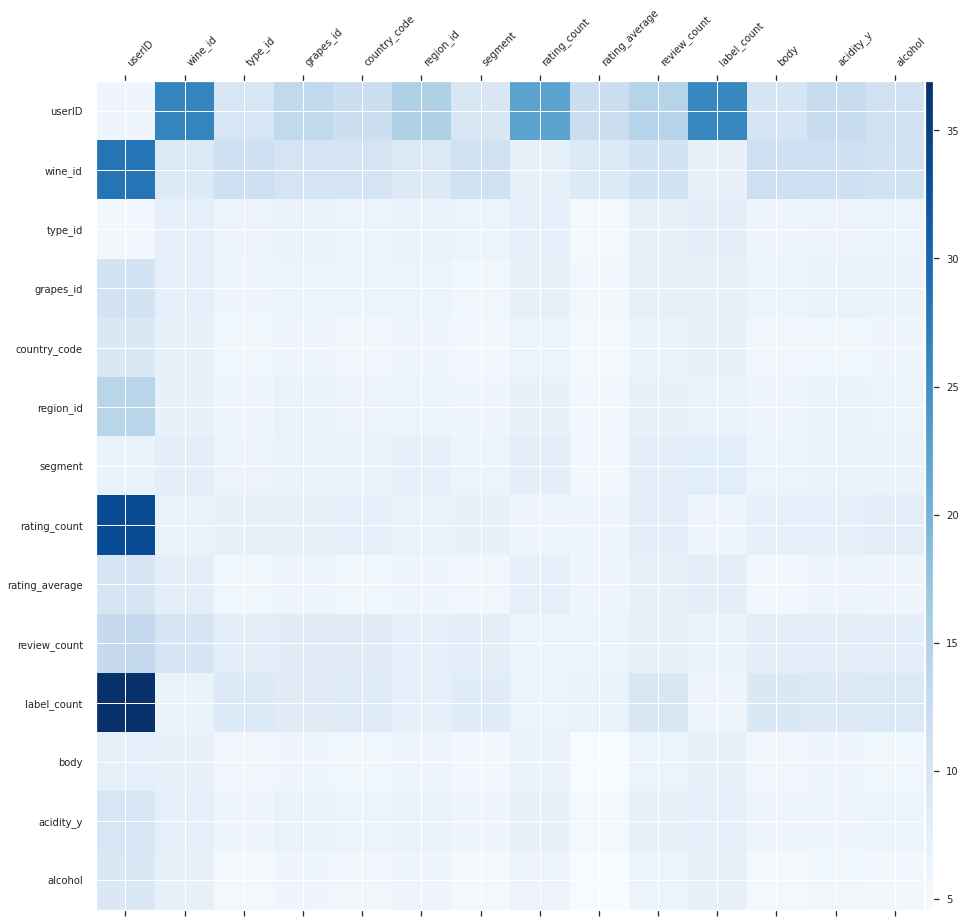

In [280]:
mat = model._cross_layer._dense.kernel
features = model._all_features
block_norm = np.ones([len(features), len(features)])

dim = model.embedding_dimension

# Compute the norms of the blocks.
for i in range(len(features)):
  for j in range(len(features)):
    block = mat[i * dim:(i + 1) * dim,
                j * dim:(j + 1) * dim]
    block_norm[i,j] = np.linalg.norm(block, ord="fro")

plt.figure(figsize=(25,25))
im = plt.matshow(block_norm, cmap=plt.cm.Blues)
ax = plt.gca()
divider = make_axes_locatable(plt.gca())
cax = divider.append_axes("right", size="1%", pad=0.001)
plt.colorbar(im, cax=cax)
cax.tick_params(labelsize=10)
# ax.set_xticklabels(np.arange(1, 15), features, ha="left")
ax.set_xticks(np.arange(0,14))
ax.set_yticks(np.arange(0,14))
_ = ax.set_xticklabels(features, rotation=45, ha="left", fontsize=10)
_ = ax.set_yticklabels(features, fontsize=10)